In [1]:
import pandas as pd
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

In [4]:
#Listings, including full descriptions and average review score
#Reviews, including unique id for each reviewer and detailed comments
#Calendar, including listing id and the price and availability for that day

In [5]:
names = ['calendar', 'listings', 'reviews']
dataframes = {}

for name in names:
    # Define the file path
    file_path = 'data/' + name + '.csv.gz'
    # Use gzip.open to decompress the file and then read it with Pandas
    with gzip.open(file_path, 'rt', encoding='utf-8') as file:
        data = pd.read_csv(file)

    dataframes[name] = data

In [6]:
listings = dataframes['listings']

## Features som burde fjernes

#### listing_url, scrape_id, last_scraped, source, host_url, host_name, host_thumbnail_url, host_picture_url, license (noen steder må man ha lisens, kunder ser ikke dette), calender_last_scraped, calendar_updated (kun NaN), name, picture_url,



In [7]:
listings = listings.drop(columns=['listing_url', 'scrape_id', 'last_scraped', 'source', 'host_url', 
    'host_name', 'host_thumbnail_url', 'host_picture_url', 'license', 'calendar_last_scraped', 
    'calendar_updated', 'name', 'picture_url'])

## Features som krever tekstsøk 
#### description, neighborhood_overview, host_about




In [8]:
listings = listings.drop(columns=["description", "neighborhood_overview", "host_about"])

#### Lagrer listings_revised slik at man kan bruke den raskt i andre notebooks

In [9]:
listings.to_csv("listings_revised.csv", index=False)

## Features som burde fjernes pga mange NaN values:
#### Neighbourhood (kan erstattes av clustering med lat/lon), bathrooms (NaN imputation muligheter med bathroom text), bedrooms (NaN imputation muligheter?)

In [10]:
listings = listings.drop(columns=["neighbourhood", "bathrooms", "bedrooms"])

### Fjerner alle max, min nights features utenom max_nights og min_nights. Ikke strengt talt ubrukelige features, men vil utvilsomt ha høy korrelasjon med max_nights og min_nights, og usikker på hvor mye ekstra forklaringsevne de tilfører problemet. 

### Beholder max og min nights ntm (next twelve months), fordi dette blir noe litt annet, tror dette er lengste og korteste planlagte/booket opphold neste tolv månedene.

In [11]:
listings = listings.drop(columns=["minimum_minimum_nights", "maximum_minimum_nights", 
        "minimum_maximum_nights", "maximum_maximum_nights"])

In [12]:
# Calculate the percentage of NaN values in each column
nan_percentage = (listings.isna().mean() * 100).round(2)

# Convert the nan_percentage Series to a DataFrame for formatting
nan_percentage_df = nan_percentage.reset_index()
nan_percentage_df.columns = ['Column', 'NaN Percentage']

# Print the nan_percentage as a nicely formatted table
print(tabulate(nan_percentage_df, headers='keys', tablefmt='pretty'))

+----+----------------------------------------------+----------------+
|    |                    Column                    | NaN Percentage |
+----+----------------------------------------------+----------------+
| 0  |                      id                      |      0.0       |
| 1  |                   host_id                    |      0.0       |
| 2  |                  host_since                  |      0.01      |
| 3  |                host_location                 |     21.34      |
| 4  |              host_response_time              |     33.96      |
| 5  |              host_response_rate              |     33.96      |
| 6  |             host_acceptance_rate             |     30.69      |
| 7  |              host_is_superhost               |      0.66      |
| 8  |              host_neighbourhood              |     19.98      |
| 9  |             host_listings_count              |      0.01      |
| 10 |          host_total_listings_count           |      0.01      |
| 11 |

#### Jeg har først lyst til å utforske NaN values i host response time, host response rate og host acceptance rate. Jeg ønsker primært å avdekke hvorvidt NaN values stammer fra feil i dataen, eller om NaN values representerer mangel på forespørsler på annonsen over annonsens livsstid eller at disse ratene "resettes" dersom man ikke har hatt forespørsler de siste X årene.

#### Et viktig moment er at dette er statistikk på HOST, ikke på annonsen. Det vil si at denne statistikken påvirkes av andre annonser enn den vi ser på.

#### last_review forteller når man sist mottok en anmeldelse fra leietaker. Dersom alle rader med NaN values på acceptance rate, response rate og response time har siste anmeldelse langt tilbake i tid, så kan dette implisere at disse ratene nullstilles etter et gitt tidspunkt (f.eks etter 2019). 

#### Ser derimot nedenfor at man finner en rad der siste anmeldelse var i 2023, men likevel har NaN values på alle tre rater. Det vil si at det finnes NaN values som ikke kan forklares, og må behandles som missing values.

In [13]:
listings["last_review"] = pd.to_datetime(listings["last_review"])

latest_nan_date_id = listings[listings['host_acceptance_rate'].isna()]['last_review'].idxmax()
listings.loc[5605]

id                                                                                       27620424
host_id                                                                                 112963302
host_since                                                                             2017-01-23
host_location                                                                        New York, NY
host_response_time                                                                            NaN
host_response_rate                                                                            NaN
host_acceptance_rate                                                                          NaN
host_is_superhost                                                                               f
host_neighbourhood                                                                            NaN
host_listings_count                                                                           1.0
host_total_listings_

#### Nå ønsker jeg å se om det er en sammenheng i NaN values mellom de tre ratene, spesifikt acceptance rate vs. response rate. Finner rader der man har NaN på acceptance rate men faktiske verdier for response. Ser også at reviews er NaN, som kan bety at slike rader inntreffer når hosten får en forespørsel men ikke aksepterer den.

In [14]:
acceptance_nan_response_notna = listings[listings['host_acceptance_rate'].isna() 
        & listings['host_response_rate'].notna()]

acceptance_nan_response_notna.iloc[4]

id                                                                                       48093831
host_id                                                                                 385609575
host_since                                                                             2021-01-22
host_location                                                                        New York, NY
host_response_time                                                                 within an hour
host_response_rate                                                                           100%
host_acceptance_rate                                                                          NaN
host_is_superhost                                                                               f
host_neighbourhood                                                                   Far Rockaway
host_listings_count                                                                           1.0
host_total_listings_

#### Sjekker derfor om tilfeller der kun acceptance rate er NaN stammer fra at hosten har svart på forespørsel men sagt nei til leietaker. Ser at det er 191 tilfeller der man har en review + reponse rate, men likevel har NaN value på acceptance rate. Altså virker det som at det er uforklarige missing values her også for acceptance rate.

In [15]:
nan_count = acceptance_nan_response_notna['last_review'].notna().sum()
print("Number of rows in which only acceptance rate is NaN and listing still has review: " + str(nan_count))


Number of rows in which only acceptance rate is NaN and listing still has review: 191


### Sjekker om NaN values i response rate og response time alltid forekommer samtidig

In [16]:
# Condition for rows where 'host_response_time' is NaN and 'host_response_rate' is not NaN
condition_time_nan_rate_notna = listings['host_response_time'].isna() & listings['host_response_rate'].notna()

# Condition for rows where 'host_response_rate' is NaN and 'host_response_time' is not NaN
condition_time_notna_rate_nan = listings['host_response_time'].notna() & listings['host_response_rate'].isna()


count_time_nan_rate_notna = condition_time_nan_rate_notna.sum()
count_time_notna_rate_nan = condition_time_notna_rate_nan.sum()

print(f"Number of rows where 'host_response_time' is NaN and 'host_response_rate' is not NaN: {count_time_nan_rate_notna}")
print(f"Number of rows where 'host_response_time' is not NaN and 'host_response_rate' is NaN: {count_time_notna_rate_nan}")


Number of rows where 'host_response_time' is NaN and 'host_response_rate' is not NaN: 0
Number of rows where 'host_response_time' is not NaN and 'host_response_rate' is NaN: 0


#### Konklusjon: Det finnes missing values for både response og acceptance rate som ikke kan forklares av mangel på opphold den siste perioden eller totalt for annonsens levetid. Videre finnes det rader der response har value mens acceptance er NaN som ikke kan forklares av mangel på faktisk opphold (review som proxy). NaN values i response rate og response time opptrer alltid sammen, som kan antyde at det finnes et mønster i hvordan NaN values oppstår for disse to kolonnene. Jeg tror sannsynligvis at det rett og slett finnes annonser som AirBnB ikke har data på når det gjelder respons og/eller acceptance. Nøyaktig hvorfor de ikke har denne dataen er jeg usikker på.



#### Først label encoder jeg "host_response_time"

In [17]:
listings["host_response_time"].unique()

sorting_order = {
    'within an hour': 4,
    'within a day': 2,
    'within a few hours': 3,
    'a few days or more': 1
}

listings['labeled_host_response_time'] = listings['host_response_time'].replace(sorting_order)


listings


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,labeled_host_response_time
0,9630344,47783628,2015-10-30,"New York, NY",NaN,NaN,NaN,f,NaN,1.0,...,5.00,4.80,5.00,f,1,0,1,0,0.06,NaN
1,3533741,17791294,2014-07-07,"New York, NY",NaN,NaN,NaN,f,Hell's Kitchen,1.0,...,NaN,NaN,NaN,f,1,0,1,0,NaN,NaN
2,9731039,50213378,2015-11-30,"New York, NY",NaN,NaN,NaN,f,Sunnyside,1.0,...,NaN,NaN,NaN,f,1,1,0,0,NaN,NaN
3,21736164,4298654,2012-12-01,"New York, NY",NaN,NaN,NaN,f,Bedford-Stuyvesant,1.0,...,5.00,5.00,5.00,f,1,1,0,0,0.03,NaN
4,22280002,67373899,2016-04-15,"New York, NY",NaN,NaN,100%,t,Bedford-Stuyvesant,1.0,...,4.91,4.94,4.92,f,1,1,0,0,1.26,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38787,27697402,21020951,2014-09-06,"New York, NY",within a few hours,100%,94%,t,NaN,1.0,...,4.83,4.61,4.61,f,1,0,1,0,0.34,3.0
38788,11871903,50032395,2015-11-28,"New York, NY",NaN,NaN,NaN,f,Upper West Side,2.0,...,5.00,5.00,5.00,f,2,0,2,0,0.01,NaN
38789,9686167,50032395,2015-11-28,"New York, NY",NaN,NaN,NaN,f,Upper West Side,2.0,...,4.86,5.00,4.86,f,2,0,2,0,0.07,NaN
38790,52459126,37694131,2015-07-06,"New York, United States",within a day,90%,100%,t,Long Island City,2.0,...,5.00,4.60,4.40,f,2,2,0,0,0.22,2.0


Correlations for acceptance rates, response rates og reviews. Det som er interessant er at det er svært lav korrelasjon mellom response rates og communication, kan være et tegn på at folk som gir ratings ikke gidder å skille mellom de ulike karakteristikkene ved oppholdet og heller ser på helhetsopplevelsen når de setter alle ratings. Ser heller ingen generell korrelasjon mellom rating og response rates & time, som kan bety at hostens tilstedeværelse på melding ikke er essensiell for en god tilværelse.

Det er også verdt å merke at response/acceptance rates og raskere response time er sterkt korrelerte. Det vil altså si at hosts som er "på" som regel er det for hele prosessen fra A til Å, og at man som regel vil svare en mulig leietaker raskt når meldingen tikker inn i appen.

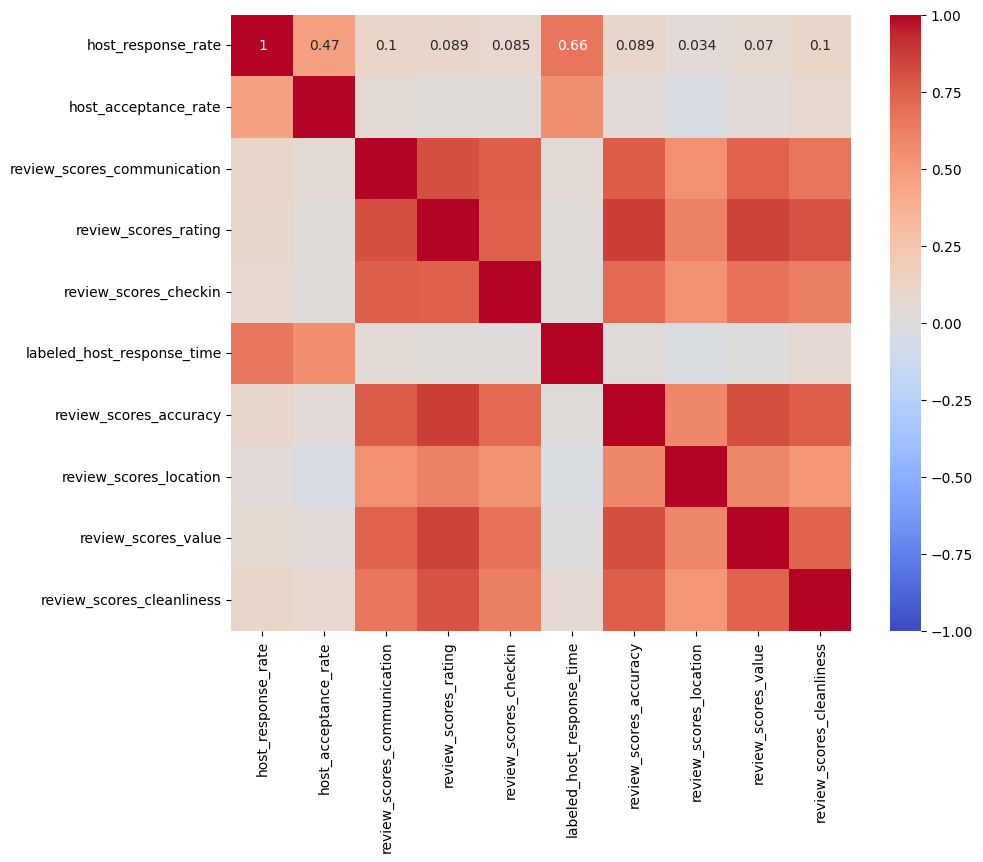

In [18]:
listings_subset = listings[["host_response_rate", "host_acceptance_rate",
    "review_scores_communication", "review_scores_rating", "review_scores_checkin", 
    "labeled_host_response_time", "review_scores_accuracy", "review_scores_location", 
    "review_scores_value", "review_scores_cleanliness"]]


listings_subset = listings_subset.dropna()

listings_subset['host_response_rate'] = listings_subset['host_response_rate'].str.rstrip('%').astype('float') 
listings_subset['host_acceptance_rate'] = listings_subset['host_acceptance_rate'].str.rstrip('%').astype('float')


correlation_matrix = listings_subset.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()